Inverse Theory is the topic of Chapter 22 of [A Guided Tour of Mathematical Methods for the Physical Sciences](http://www.cambridge.org/nz/academic/subjects/physics/mathematical-methods/guided-tour-mathematical-methods-physical-sciences-3rd-edition#KUoGXYx5FTwytcUg.97). This notebook provides calculations on a small -- and idealized -- inverse problem of finding a karst with noisy gravity measurements to show you the workings of Bayesian inversion. In Chapter 22, we tackled this as a damped least squares problem, and the end of the chapter ends with a discussion on a Bayesian approach to inverse theory. Here, we extend the example to this Bayesian framework (and in the end show the link between the two strategies).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Every inverse problem is related to a forward problem. In geophysics, our data are usually the result of doing some experiment on Earth that obeys the Laws of Physics. The goal is to obtain the physical parameters of the Earth that are responsible for these data. In this case, the physics to find the depth and mass of a karst involves measurements of the (negative) gravitational force anomaly at and above the surface of the Earth. (When karsts collapse, they can form sinkholes!)

## Newton's Law of gravitation
Newton postulated that the gravitational acceleration on a unit test mass $m$ due to a mass $M$ is proportional to $M$ and inversely proportional to their squared distance $R^2$. It took time, and heroic efforts by Michell and Cavendish to estimate the proportionality constant $G$:

In [3]:
import scipy.constants

def F(M,R):
    G = scipy.constants.G # Universal Constant (m^3⋅kg^−1⋅s^−2)
    return G*M/R**2

## Our karst

A particular underground void (or, [karst](https://en.wikipedia.org/wiki/Karst)) results in a mass deficiency of 500000 kg, due to missing rock. The centre of this karst is at 15 m under ground. 
We take two measurements (for reasons you can read about in Chapter 22!) of the gravitational acceleration anomaly: one at the surface and one on a 10 m ladder. Both measurements are done right over the karst (how we know the lateral position, remains a mystery to this day):

In [4]:
dM = 500000 # the amount of missing mass in kg
r = 15 # true depth in m
m_true = np.array([dM,r]) 
rL=10 # second datum from a ladder of height rL in m
d_true = [F(dM,r), F(dM,r+rL)] # noise free data in N
print(d_true)

[1.483128888888889e-07, 5.3392640000000005e-08]


Technically, these data form a negative force anomaly, due to the lack of rock that *is* the void. 

## Noisy data
Let's add some noise to the data, drawn from a Gaussian distribution with mean zero, and some standard deviation:

In [5]:
mu, sigma = 0, 0.15 # mean and standard deviation
sigma_d = d_true*np.random.normal(mu, sigma, 2)
d = np.array(d_true + sigma_d)
print(d)

[1.28417250e-07 6.16325436e-08]


## Prior information
From years and years of finding karsts, we know that karsts in this area fit the following parameters:

In [6]:
dM0 = 600000 # average mass (deficiency) of a karst
r0= 12 # average depth
m0 = np.array([dM0,r0])
std =0.25 # standard deviation on these parameters
sigma_m = m_true*std 
print(m0,sigma_m)

[600000     12] [1.25e+05 3.75e+00]


Let's generate a 2d grid as search space for models with different masses and depths:

In [7]:
x = np.linspace(100000, 800000, 200)
y = np.linspace(5, 20, 200)
xx, yy = np.meshgrid(x, y)

The prior distribution is then 
\begin{equation}
\label{Basinv.2}
p( {\bf m }  ) \propto \exp \left( - \frac{ \| {\bf m} - {\bf m}_0 \|^2 }{ 2 \sigma_m^2}
\right) .
\end{equation} 

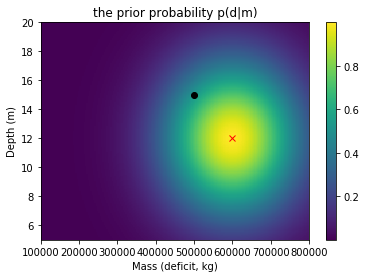

In [8]:
pm = 0.5*(((xx-m0[0])/sigma_m[0])**2+ ((yy-m0[1])/sigma_m[1])**2)

# The next line finds the coordinates of the maximum value of pmd:
maxpm = np.argmax(np.exp(-pm), axis=None) # is the x*y index (single value), to unravel x and y:
MLE=np.unravel_index(maxpm, pm.shape)

fig, ax = plt.subplots()
ax.set_title('the prior probability p(d|m)')
ax.set_xlabel('Mass (deficit, kg)')
ax.set_ylabel('Depth (m)')
c = ax.pcolormesh(x, y, np.exp(-pm))
fig.colorbar(c, ax=ax)
ax.plot(dM,r,'ko')
ax.plot(x[MLE[1]],y[MLE[0]],'rx')
plt.show()

The black dot is the "true" model, and the red "x" the maximum value of the prior distribution.

The data tell us that $p({\bf d}|{\bf m})$ is
\begin{equation}
\label{Basinv.3}
p( {\bf d} | {\bf m }  ) \propto \exp \left( - \frac{\| {\bf d} - {\bf F}( {\bf m}) \|^2}{2 \sigma_d^2}
\right) .
\end{equation} 

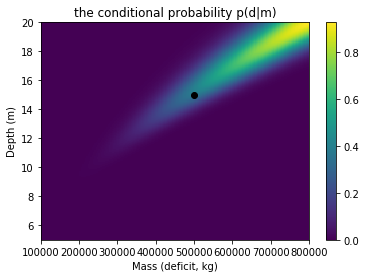

In [9]:
pdm = 0.5*(((d[0]-F(xx,yy))/sigma_d[0])**2 + ((d[1]-F(xx,yy+rL))/sigma_d[1])**2)
fig, ax = plt.subplots()
ax.set_title('the conditional probability p(d|m)')
ax.set_xlabel('Mass (deficit, kg)')
ax.set_ylabel('Depth (m)')
c = ax.pcolormesh(x, y, np.exp(-pdm))
ax.plot(dM,r,'ko')
fig.colorbar(c, ax=ax)
plt.show()

The linear feature of p(d|m) says that the data struggle to help us distinguish between shallow+small karsts, and deep+big ones. Note that we "know" the data uncertainty. In real life, this is unlikely...

## The posterior
When we apply Bayes' formula, we get a posterior distribution 
\begin{equation}
\label{Basinv.4}
p( {\bf m } | {\bf d } ) \propto
 \exp \left( - \frac{\| {\bf d} - {\bf F} ( {\bf m} ) \|^2}{2 \sigma_d^2}
 - \frac{ \| {\bf m} - {\bf m}_0 \|^2 }{ 2 \sigma_m^2}
\right) .
\end{equation}

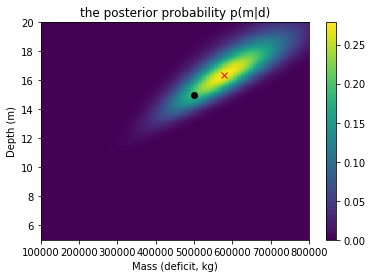

In [10]:
pmd = np.exp(-(pm+pdm))

# The next line finds the coordinates of the maximum value of pmd:
maxpmd = np.argmax(pmd, axis=None) # is the x*y index (single value), to unravel x and y:
MLE=np.unravel_index(maxpmd, pmd.shape)

fig, ax = plt.subplots()
ax.set_title('the posterior probability p(m|d)')
ax.set_xlabel('Mass (deficit, kg)')
ax.set_ylabel('Depth (m)')
c = ax.pcolormesh(x, y, pmd)
ax.plot(dM,r,'ko')
ax.plot(x[MLE[1]],y[MLE[0]],'rx')
fig.colorbar(c, ax=ax)
plt.show()

The posterior distribution represents a data-driven update to the prior knowledge of the possible karst models. One can see that the "bull's eye" in the posterior is generally closer to the true parameters of the karst than the the prior bull's eye. More importantly, the posterior distribution should have narrowed the range of models that could represent the karst. (But as we added noise to the data, this may not be true for every realization of "noisy data").

## The maximum likelihood estimator
This bull's eye is the maximum likelihood estimator, and at the end of Chapter 22 you can read how for linear inverse problems (this one is not! Can you see from F(m) why?), this estimator is the same as the solution to the damped least squares solution, as you can learn at the end of Chapter 22.

## Your assigment: create an ensemble of maximum likelihood estimators
Build a loop, as if you came back every day for 100 days to repeat the noisy gravity measurements. In practice, this means you generate a new vector ${\bf d}$ Plot the maximum likelihood estimator of the posterior for each "day". If the errors are mean zero, we hope you see that the solutions have a mean that is centered on the "true" depth and mass of the karst! 